# Notebook Title

Last modified: 

**Executive summary:**  

Because the target variable does not distingusih between prediabetes and diabetes, people with prediabetes and people with diabetes are both addressed as people with diabetes throughought this notebook

-----

Cite this CDC article: https://www.cdc.gov/diabetes/php/data-research/index.html

Load necessary variables:

Requirements:  
- pandas 2.2.3
- matplotlib 3.10.1
- seaborn 0.13.2
- scikit-learn 1.6.1
- humanfriendly 10.0

Optional but recommended:
- tqdm 4.66.4
- ipywidgets 8.1.6

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import humanfriendly as hf
from copy import copy
import numpy as np

# sns.set_theme(rc={"figure.dpi": 150},style='white')

# import warnings
# warnings.filterwarnings('ignore')

import os

def EJrename(src,dst):
    try:
        os.rename(src, dst)
    except FileExistsError:
        os.remove(dst)
        os.rename(src, dst)


## Step 1: Data Preprocessing

Load data and perform checks

In [2]:
df = pd.read_csv('raw_data/diabetes_binary_health_indicators_BRFSS2015.csv')
y = df['Diabetes_binary']
df = df.drop('Diabetes_binary',axis=1)
df.head(2)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0


In [3]:
#Check for NaNs
print(f'There are {df.isna().sum().sum()} NaNs in the dataset')
print(f'There are {y.isna().sum()} NaNs in the target variable')

#Is the dataset well balanced?
print(f'There are {hf.format_number(int(y.sum()))} people with diabetes in the dataset, {100*y.sum()/len(y):.2f}% of the {hf.format_number(len(y))} samples.')

There are 0 NaNs in the dataset
There are 0 NaNs in the target variable
There are 35,346 people with diabetes in the dataset, 13.93% of the 253,680 samples.


In [4]:
38.4/331+97.6/331

# 97.6/331

0.41087613293051356

According to the CDC, just over 40% of all US population have either diabetes (11.6%) or prediabetes (29.5%)* . This is not only a stagering number, but it means that our database contains much fewer positives than our target population.

I will separate 10% of the total positives in the original dataset while keeping a target potive ratio of 40% in that validation cohort. Similarly, whenever k-fold validation is performed, a this positive rate of 40% will be maintained by using [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) from `sklearn`.

*In millions: 38.4 persons with diabetes and 97.6 adults with prediabetes out of an estimated 331 persons in the U.S. [source](https://www.cdc.gov/diabetes/php/data-research/index.html): https://www.cdc.gov/diabetes/php/data-research/index.html


## Step 2: Exploratory Data Analysis

### Features' values distriutions

In [5]:
# y.hist()

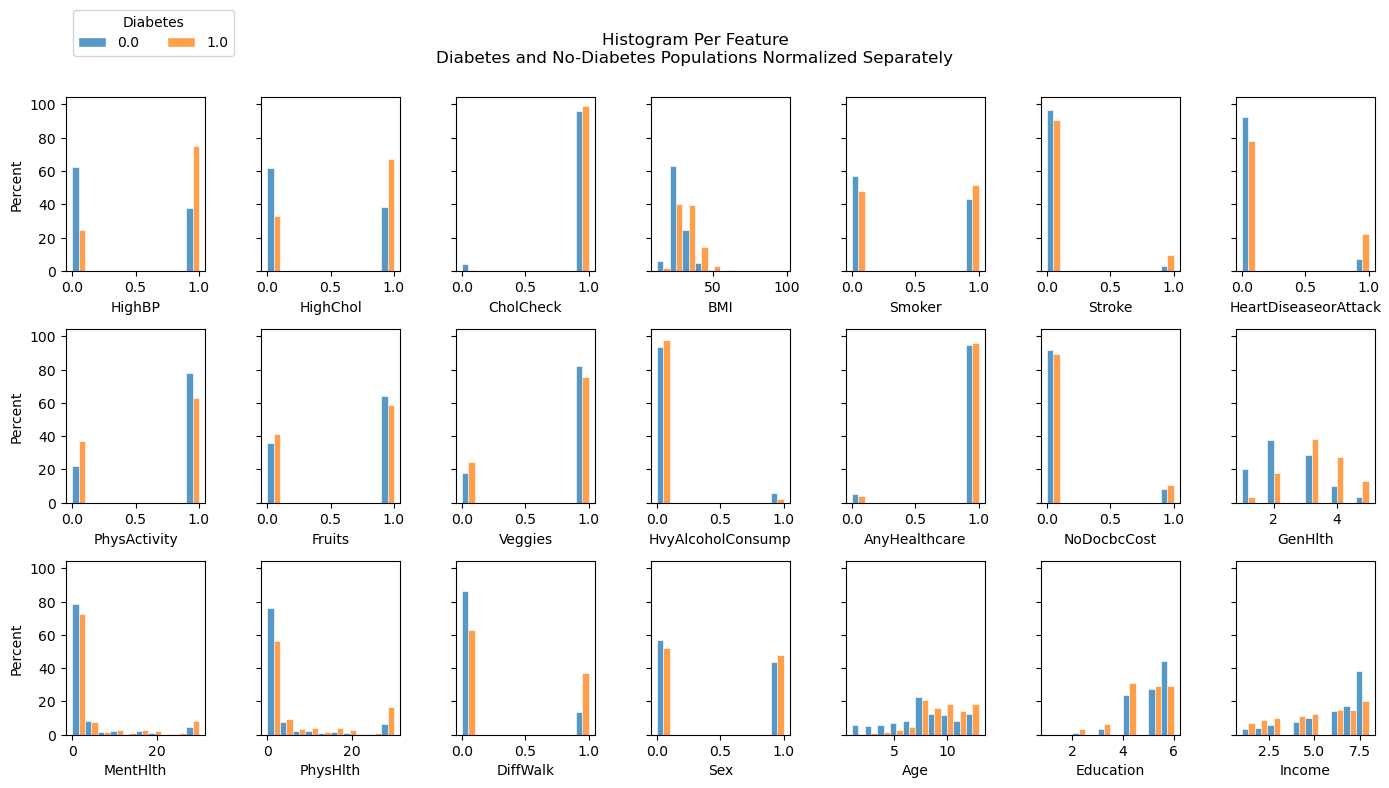

In [6]:

to_plot = df.copy()
to_plot['Diabetes'] = y

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(14, 8),sharey=True)
# Flatten the axes array (makes it easier to iterate over)
axes = axes.flatten()

# Loop through each column and plot a histogram
for i, column in enumerate(df.columns):
    ax = sns.histplot(data=to_plot[[column,'Diabetes']],hue='Diabetes',x=column,stat="percent",
                      common_norm=False,bins=10,multiple="dodge",ax=axes[i], edgecolor='white',)
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Percent')
    
    # Use only one legend for the whole plot
    if i== 0:
         plot_legend = axes[i].get_legend()
         sns.move_legend(ax, "lower left",bbox_to_anchor=(0, 1.2), title='Diabetes', ncol=2)
    else:
         axes[i].get_legend().remove() #remove the redundant legend

plt.tight_layout()
plt.suptitle('Histogram Per Feature\nDiabetes and No-Diabetes Populations Normalized Separately',y=0.95)
plt.show()

Note: Age is an ordinal variable that maps to the real age of the person as described in [this notebook](https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook): "1 is 18-24 all the way up to 13 wis 80 and older. 5 year increments. [Removed] 14 because it is don't know or missing"

### Looking into feature correlations

In [7]:
# to_plot.corr()

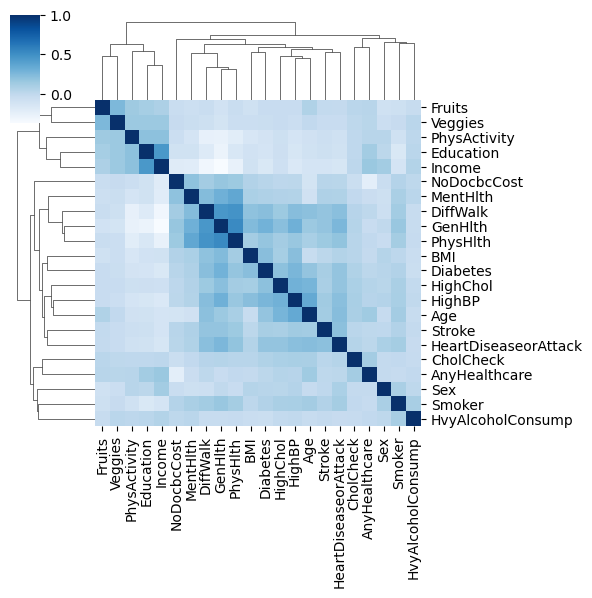

In [8]:
# sns.heatmap(data=to_plot.corr(),cmap='Blues')
sns.clustermap(data=to_plot.corr(),cmap='Blues',figsize=(6,6))

There are some slighlty correlated variables, e.g., Geneneral Health with Physical Health ($\rho$=0.52), and Difficulty walking ($\rho$=0.46). But no two variables are higly correlated, i.e., the max correlation is 0.52.

General Health is also the feature that has the highest correlation with the target variable $\rho$=0.29.

## Step 3: Model Selection

### Creating a validation set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.1, random_state=42,stratify=y)

### Initial Model Fit 

In [10]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [11]:
# train_and_predict(df.fillna(0),y,all_regs['L2Regression'],df.fillna(0).head())

def train_and_predict(X_train,y_train,model,X_test=None,y_test=None,folds=1):
    X_test = X_test[X_train.columns] # Just making sure the columns are in the same order

    if folds==1:
        model = model.fit(X_train,y_train)
        if X_test is None:
            print('WARNING: No predictions')
            return model,None,None,None,None,None

        y_pred = model.predict(X_test)
        # y_probs = model.predict_proba(X_test)
        # cm = confusion_matrix(y_test, y_pred)
        # tn, fp, fn, tp = cm.ravel()

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        p,r,f,_ = precision_recall_fscore_support(y_test,y_pred,average='binary',pos_label=1)
        return model,y_pred,auc,p,r,f

    else:
        #performing k-fold validation

        # K-fold cross-validation
        kf = StratifiedKFold(n_splits=folds,shuffle=True,random_state=42)

        precision_scores = []
        recall_scores = []
        f1_scores = []
        auc_scores = []

        for train_index, test_index in kf.split(X_train,y_train):
            currX_train = X_train.iloc[train_index]
            currX_test = X_train.iloc[test_index]
            curry_train, curry_test = y_train.iloc[train_index], y_train.iloc[test_index]
            
            model.fit(currX_train, curry_train)
            y_pred = model.predict(currX_test)

            fpr, tpr, thresholds = metrics.roc_curve(curry_test, y_pred, pos_label=1)
            auc = metrics.auc(fpr, tpr)

            p,r,f,_ = precision_recall_fscore_support(curry_test,y_pred,average='binary',pos_label=1)
            
            precision_scores.append(p)
            recall_scores.append(r)
            f1_scores.append(f)
            auc_scores.append(auc)

        #These values won't make sense if we return them.
        model = None
        y_pred = None

        return model,y_pred,auc_scores,precision_scores,recall_scores,f1_scores

Sice the data consist of both binary data and some categorial variables. The following classifiers have been chosen for the first round of model fit:

In [30]:
# These next three lines are lefover from a "round 0" where I blindly tried all estimators to confirm that the ones that are theoretically solid produce the best results
# from sklearn.utils import all_estimators
# estimators = all_estimators(type_filter='classifier')
# estimators = all_estimators()

from sklearn.naive_bayes import CategoricalNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

all_class = {} #dictionary to store all classifiers
#3 Versions of Naive Bayes
all_class['CategoricalNB']= CategoricalNB()
all_class['BernoulliNB']= BernoulliNB()
all_class['GaussianNB']= GaussianNB() #Data does not look strictly gaussian, but sometimes it's an acceptable approximation
#Logistic regression
all_class['LogisticRegression']=LogisticRegression(random_state=42,max_iter=1000)
# Boundary-based/discriminant methods
all_class['LinearDiscriminantAnalysis'] = LinearDiscriminantAnalysis()
all_class['QuadraticDiscriminantAnalysis'] = QuadraticDiscriminantAnalysis()
# Distance/Neighbors-based methods
all_class['KNeighborsClassifier'] = KNeighborsClassifier()
all_class['NearestCentroid'] = NearestCentroid()
#Ensemble classifiers
all_class['AdaBoostClassifier'] = AdaBoostClassifier(random_state=42)
all_class['HistGradientBoostingClassifier'] = HistGradientBoostingClassifier(random_state=42) # faster than GradientBoostingClassifier
all_class['RandomForestClassifier'] = RandomForestClassifier(random_state=42)
#Finally adding a Neural-Network approach to cover all the bases
all_class['MLPClassifier'] = MLPClassifier(random_state=42,max_iter=1000)



In [31]:
def train_and_predict_all_models(all_classifiers,X_train,y_train,X_test=None,y_test=None,folds=1):
    trained_models ={}
    elapsed = None
    out = pd.DataFrame()
    i = 0
    for name,model in (pbar:=tqdm(zip(all_classifiers.keys(),all_classifiers.values()),total=len(all_classifiers))):
        start_time = time.time()
        pbar.set_description(f'{name} | previous run: {elapsed}')
        if X_test is None:
            model,y_pred,auc,p,r,f = train_and_predict(X_train=X_train,y_train=y_train,model=model,X_test=X_train,y_test=y_train,folds=folds)
        else:
            model,y_pred,auc,p,r,f = train_and_predict(X_train=X_train,y_train=y_train,model=model,X_test=X_test,y_test=y_test,folds=folds)
        elapsed = hf.format_timespan(time.time()-start_time)

        trained_models[name] = copy(model)
        out.loc[i,'Name'] = name
        out.loc[i,'avg AUC'] = np.mean(auc)
        out.loc[i,'med AUC'] = np.median(auc)
        out.loc[i,'std AUC'] = np.std(auc)
        out.loc[i,'avg Precision'] = np.mean(p)
        out.loc[i,'med Precision'] = np.median(p)
        out.loc[i,'std Precision'] = np.std(p)
        out.loc[i,'avg Recall'] = np.mean(r)
        out.loc[i,'med Recall'] = np.median(r)
        out.loc[i,'std Recall'] = np.std(r)
        out.loc[i,'avg F1'] = np.mean(f)
        out.loc[i,'med F1'] = np.median(f)
        out.loc[i,'std F1'] = np.std(f)
        out.loc[i,'Elapsed'] = elapsed
        print(name,f"mean auc={np.mean(auc):.2f}(\u03C3={np.std(auc):.2f})",f"mean p={np.mean(p):.2f}(\u03C3={np.std(p):.2f})",
              f"mean r={np.mean(r):.2f}(\u03C3={np.std(r):.2f})",f"mean f={np.mean(f):.2f}(\u03C3={np.std(f):.2f})",
              f"|{elapsed}")
        i+=1
    return out,trained_models

"Breath-first" approach. Testing many classifiers with default parametners:

In [25]:
defaults_df, default_trained_models = train_and_predict_all_models(all_class,X_train,y_train,folds=5)

  0%|          | 0/13 [00:00<?, ?it/s]

DecisionTreeClassifier mean auc=0.60(σ=0.00) mean p=0.29(σ=0.00) mean r=0.32(σ=0.01) mean f=0.30(σ=0.00) |3.61 seconds
CategoricalNB mean auc=0.69(σ=0.00) mean p=0.38(σ=0.00) mean r=0.51(σ=0.00) mean f=0.43(σ=0.00) |0.64 seconds
BernoulliNB mean auc=0.62(σ=0.00) mean p=0.39(σ=0.00) mean r=0.33(σ=0.00) mean f=0.36(σ=0.00) |0.57 seconds
GaussianNB mean auc=0.69(σ=0.00) mean p=0.32(σ=0.00) mean r=0.57(σ=0.01) mean f=0.41(σ=0.00) |0.62 seconds
LogisticRegression mean auc=0.57(σ=0.00) mean p=0.54(σ=0.01) mean r=0.16(σ=0.00) mean f=0.24(σ=0.01) |32.32 seconds
LinearDiscriminantAnalysis mean auc=0.59(σ=0.00) mean p=0.51(σ=0.01) mean r=0.21(σ=0.00) mean f=0.29(σ=0.01) |2.45 seconds
QuadraticDiscriminantAnalysis mean auc=0.68(σ=0.00) mean p=0.32(σ=0.00) mean r=0.56(σ=0.01) mean f=0.40(σ=0.00) |1.53 seconds
KNeighborsClassifier mean auc=0.57(σ=0.00) mean p=0.40(σ=0.01) mean r=0.19(σ=0.00) mean f=0.26(σ=0.00) |2 minutes and 13.43 seconds
NearestCentroid mean auc=0.64(σ=0.00) mean p=0.28(σ=0.00) m

Because this is an early screening tool *recall* is an important metric. Recall is also known as the true positive rate, meaning this is the proportion of all positve (diabetes) samples that are found by our classifier. This value is important because an early screening tool should aim to find as many true positives as possible.

However, perfect recall could be achieved by simply flagging every patient as "1" for diabetes. So we must also consider the *precision* of the model (the proportion of the patients predicted to have diabetes by the model who actually have diabetes).

To balance these two we will focus on the *F1* score, which is the harmonic mean of precision and recall. However, we will keep an eye on recall as a way to decide between different models with similar F1 scores.

In [28]:
defaults_df.sort_values(by='avg F1',ascending=False)

,Name,avg AUC,med AUC,std AUC,avg Precision,med Precision,std Precision,avg Recall,med Recall,std Recall,avg F1,med F1,std F1,Elapsed
1,CategoricalNB,0.687096,0.686788,0.001097,0.378241,0.378244,0.001626,0.509887,0.509274,0.003249,0.434298,0.433561,0.001236,0.64 seconds
3,GaussianNB,0.688615,0.688967,0.003025,0.323458,0.323965,0.001856,0.570338,0.570732,0.006772,0.412798,0.413318,0.003238,0.62 seconds
6,QuadraticDiscriminantAnalysis,0.680712,0.680481,0.002335,0.315891,0.315635,0.001628,0.556537,0.557058,0.005322,0.403021,0.403158,0.002542,1.53 seconds
2,BernoulliNB,0.623452,0.623932,0.001379,0.391581,0.389834,0.002961,0.329886,0.330871,0.003015,0.358087,0.358444,0.002464,0.57 seconds
8,NearestCentroid,0.640199,0.640600,0.001938,0.276483,0.277131,0.002589,0.486530,0.488135,0.003856,0.352586,0.352160,0.002561,0.56 seconds
0,DecisionTreeClassifier,0.595896,0.595876,0.002276,0.289150,0.289515,0.002137,0.318569,0.318139,0.005830,0.303133,0.303153,0.003590,3.61 seconds
5,LinearDiscriminantAnalysis,0.587247,0.587980,0.002426,0.510303,0.508100,0.010305,0.206595,0.207796,0.004575,0.294100,0.295770,0.005919,2.45 seconds
9,AdaBoostClassifier,0.577778,0.577547,0.001010,0.538279,0.538028,0.008940,0.180661,0.180132,0.002310,0.270499,0.269901,0.002610,20.71 seconds
7,KNeighborsClassifier,0.572525,0.572474,0.001584,0.398602,0.401608,0.006569,0.191946,0.192707,0.003211,0.259097,0.259150,0.003702,2 minutes and 13.43 seconds
11,RandomForestClassifier,0.571875,0.572391,0.001194,0.489276,0.490608,0.011442,0.173022,0.173530,0.002640,0.255598,0.256887,0.003064,1 minute and 16.11 seconds


## Step 4: Feature Selection & Hyperparameter Tuning

### 4.1: Naive/Ad-hoc feature selection

The CDC reports the following variables as risk factors for diabetes:
- Smoking --> Smoker==1
- High Body Mass Index --> BMI ≥25.0
- Physical inactivity --> PhysActivity==0
- ~~Hihgh A1C --> Feature not present~~
- High blood pressure --> HighBP==1
- High cholesterol --> HighChol==1

As a base-level predictor, we will use only these variables to build a classifier. Additionally, we will pay extra attention to these features in the feature selection and feature importance steps. It is important to validate our numerical results with clinically validated observations.

In [32]:
rf_df, rf_trained_models = train_and_predict_all_models(all_class,df[['Smoker','BMI','PhysActivity','HighBP','HighChol']],y,folds=5)

  0%|          | 0/12 [00:00<?, ?it/s]

CategoricalNB mean auc=0.59(σ=0.01) mean p=0.44(σ=0.00) mean r=0.24(σ=0.01) mean f=0.31(σ=0.01) |0.31 seconds
BernoulliNB mean auc=0.54(σ=0.00) mean p=0.37(σ=0.01) mean r=0.12(σ=0.00) mean f=0.18(σ=0.00) |0.3 seconds
GaussianNB mean auc=0.60(σ=0.00) mean p=0.41(σ=0.01) mean r=0.25(σ=0.01) mean f=0.31(σ=0.01) |0.26 seconds
LogisticRegression mean auc=0.52(σ=0.00) mean p=0.49(σ=0.01) mean r=0.05(σ=0.00) mean f=0.09(σ=0.00) |2.83 seconds
LinearDiscriminantAnalysis mean auc=0.53(σ=0.00) mean p=0.48(σ=0.01) mean r=0.08(σ=0.00) mean f=0.14(σ=0.01) |0.48 seconds
QuadraticDiscriminantAnalysis mean auc=0.54(σ=0.00) mean p=0.43(σ=0.01) mean r=0.11(σ=0.00) mean f=0.18(σ=0.01) |0.34 seconds
KNeighborsClassifier mean auc=0.56(σ=0.01) mean p=0.30(σ=0.01) mean r=0.20(σ=0.02) mean f=0.24(σ=0.02) |23.25 seconds
NearestCentroid mean auc=0.64(σ=0.00) mean p=0.23(σ=0.00) mean r=0.58(σ=0.01) mean f=0.33(σ=0.00) |0.27 seconds
AdaBoostClassifier mean auc=0.53(σ=0.00) mean p=0.52(σ=0.02) mean r=0.07(σ=0.01) m

In [27]:
rf_df.sort_values(by='avg F1',ascending=False)

,Name,avg AUC,med AUC,std AUC,avg Precision,med Precision,std Precision,avg Recall,med Recall,std Recall,avg F1,med F1,std F1,Elapsed
8,NearestCentroid,0.637399,0.638297,0.002811,0.234964,0.235029,0.001784,0.581112,0.584866,0.007507,0.334617,0.335279,0.002619,0.27 seconds
3,GaussianNB,0.595203,0.593903,0.003300,0.405577,0.402726,0.006552,0.249618,0.247808,0.006588,0.309026,0.306240,0.006902,0.26 seconds
1,CategoricalNB,0.593809,0.591502,0.005148,0.438202,0.438474,0.004647,0.236717,0.230867,0.011912,0.307268,0.302474,0.011040,0.27 seconds
7,KNeighborsClassifier,0.562872,0.563913,0.006878,0.302953,0.295619,0.012768,0.200419,0.208092,0.018453,0.240802,0.244251,0.015951,24.22 seconds
2,BernoulliNB,0.543796,0.543649,0.001750,0.366304,0.368534,0.005854,0.121654,0.121092,0.003828,0.182635,0.181934,0.004916,0.28 seconds
6,QuadraticDiscriminantAnalysis,0.544150,0.544290,0.002018,0.434447,0.433880,0.009722,0.111866,0.112463,0.004016,0.177910,0.178427,0.005851,0.33 seconds
5,LinearDiscriminantAnalysis,0.533081,0.533678,0.001669,0.479412,0.480833,0.011757,0.080264,0.081471,0.003357,0.137496,0.139557,0.005352,0.48 seconds
9,AdaBoostClassifier,0.529809,0.529566,0.002326,0.516697,0.512980,0.024360,0.070418,0.069873,0.006566,0.123698,0.122993,0.009523,10.66 seconds
11,RandomForestClassifier,0.527268,0.527422,0.002016,0.510204,0.510858,0.014402,0.064562,0.064074,0.004342,0.114585,0.114307,0.007068,23.59 seconds
0,DecisionTreeClassifier,0.526022,0.525881,0.002683,0.511904,0.508457,0.016758,0.061535,0.061678,0.005997,0.109782,0.109851,0.009751,0.52 seconds


In [ ]:
# Effectively all of the classifiers lose performance in every metric.
100*(rf_df.set_index('Name').drop('Elapsed',axis=1)-defaults_df.set_index('Name').drop('Elapsed',axis=1))/(defaults_df.set_index('Name').drop('Elapsed',axis=1))

## Step 5: Model Validation and Results Interpretation

## Step 6: Model Deployment

In [ ]:
#Note: to export this notebook as a PD, run: `jupyter nbconvert --to webpdf NAME_OF_NB.ipynb` in the terminal.